In [22]:
import numpy as np
import pandas as pd

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import ShuffleSplit


RANDOM_STATE = 42
np.random.seed(seed=RANDOM_STATE)

In [3]:
raw_data = pd.read_csv("creditcard.csv")

In [24]:
X = raw_data.drop(columns=["Class"])
y = raw_data["Class"].copy()

inliers = X[y==0]
outliers = X[y==1]

test_ratio = 0.2
splitter = ShuffleSplit(n_splits=1, test_size=test_ratio)

for train_index,test_index in splitter.split(inliers):
    inlier_train = inliers.iloc[train_index]
    inlier_test = inliers.iloc[test_index]

In [27]:
GMM = GaussianMixture()
GMM.fit(inlier_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=1, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [35]:
print("Training Likelihood: {:.3f}".format(GMM.score(inlier_train)))

Training Likelihood: -53.312


## Seems to be overfitting to training data

In [48]:
print("Testing Likelihood: {:.3f}".format(GMM.score(inlier_test)))
print("Outlier Likelihood: {:.3f}".format(GMM.score(outliers)))

Testing Likelihood: -53.130
Outlier Likelihood: -1725.018


In [49]:
print("Testing BIC: {:.3f}".format(GMM.bic(inlier_test)))
print("Outlier BIC: {:.3f}".format(GMM.bic(outliers)))

Testing BIC: 6047651.223
Outlier BIC: 1700485.868


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1fc12c88>]],
      dtype=object)

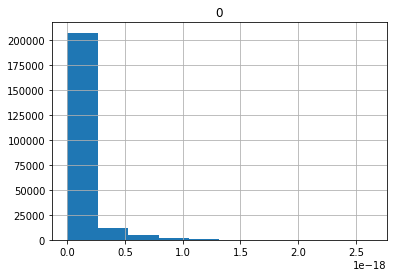

In [51]:
scores = pd.DataFrame(np.exp(GMM.score_samples(inlier_train)))
scores.hist()

In [29]:
preds = pd.Series(GMM.predict(inlier_test))
preds.value_counts()

0    56863
dtype: int64

In [31]:
probs = pd.DataFrame(GMM.predict_proba(inlier_test))
probs.mean()

0    1.0
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1e79dcc0>]],
      dtype=object)

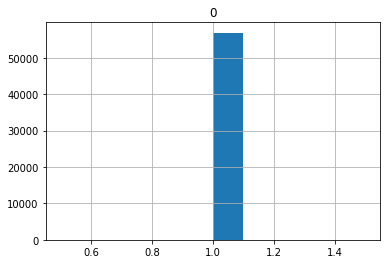

In [32]:
probs.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a20e17ac8>]],
      dtype=object)

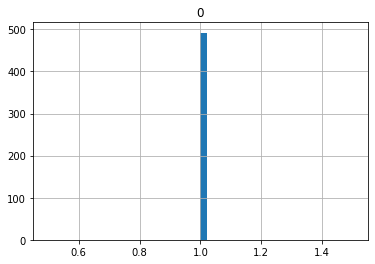

In [50]:
outlier_probs = pd.DataFrame(GMM.predict_proba(outliers))
outlier_probs.hist(bins=50)

## Gridsearch to get better density estimation...